# NIRCam PSF Fitting

This notebook attempts to fit the NIRCam PSF using multiple Gaussian functions and a window in Fourier space.

The notebook requires numpy, matplotlib, tensorflow, tensorflow_probability, webbpsf, astropy.io fits. A path environmental variable also needs to be set.

In [283]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import os
!export WEBBPSF_PATH=/data/groups/comp-astro/jades/webbpsf-data 
os.environ["WEBBPSF_PATH"] = "/data/groups/comp-astro/jades/webbpsf-data"
import webbpsf
from astropy.io import fits
tfd = tfp.distributions

### Load NIRCam PSF

In [319]:
nc = webbpsf.NIRCam()
#nc.filter = 'F200W'
nc.filter = 'F444W'

psf = nc.calc_psf(detector_oversample=1,fft_oversample=4)
#plt.imshow(psf[0].data)
#webbpsf.display_psf(psf)
data_F200W = psf[0].data

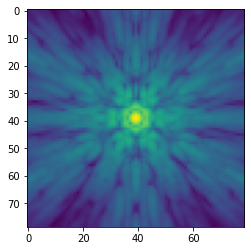

In [320]:
plt.imshow(np.log10(data_F200W))

### Define Loss and Optimizer Functions

In [321]:
# Loss function
loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)

#SGD Optimizer
#optimizer = tf.optimizers.SGD(learning_rate=0.0001)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

### Define MSE TF Functions

In [322]:
#define mse
@tf.function
def mse(y_true_in, y_pred_in):
    return loss_fn(y_true=y_true_in,y_pred=y_pred_in)
#define mse in log
@tf.function
def mse_log(y_true_in, y_pred_in):
    return loss_fn(y_true=np.log10(y_true_in),y_pred=np.log10(y_pred_in))

### Define grid positions

In [323]:
def gridxy(nx=161,ny=161):
    xl = np.arange(nx,dtype=np.float32)
    yl = np.arange(ny,dtype=np.float32)
    x,y = np.meshgrid(xl,yl)
    xy = np.dstack((x,y))
    return xy

### Compute FFT of PSF

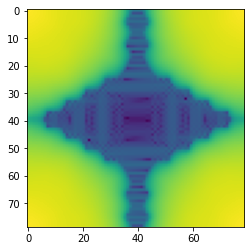

In [324]:
data_F200W_fft = np.absolute(np.fft.fft2(data_F200W))
plt.imshow(np.log10(data_F200W_fft))

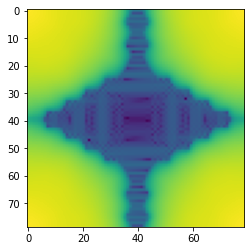

In [325]:
data_F200W_fft = np.absolute(np.fft.fft2(data_F200W))
plt.imshow(np.log10(data_F200W_fft))

In [326]:
#def gridxy(nx=161,ny=161):
#    xl = np.arange(nx,dtype=np.float32)
#    yl = np.arange(ny,dtype=np.float32)
#    x,y = np.meshgrid(xl,yl)
#    xy = np.dstack((x,y))
#    return xy
xtest = gridxy()
#print(xtest)
print(xtest[161-1-80,161-1-80])

[80. 80.]


### Perform three gaussian fit to PSF with Configuration and Fourier Space MSE loss with Tukey FFT Filter

In [328]:
nx = data_F200W.shape[0]
ny = data_F200W.shape[1]
#initialize xy grid
xy = gridxy(nx=nx,ny=ny)

#Epoch 9000 | Loss 0.0004640268415721366 a_0:1.3175196647644043 a_1:0.8137475848197937 a_2:0.26381099224090576
#Epoch 9000 | Loss 0.0004640268415721366 s_x_a:0.8608774542808533 s_y_a:0.8645910620689392 s_x_b:6.919021129608154 s_y_b:6.316895008087158  s_2_x:20.22382354736328 s_2_y:20.15462303161621
#Epoch 9000 | Loss 0.0004640268415721366 t_a:0.13926561176776886
#Epoch 9000 | Loss 0.0004640268415721366 sum model:0.9961426258087158 sum:0.9840865672496912

#sig x
a_0 = tf.Variable(1.3175196647644043, name='a_0')
a_1 = tf.Variable(0.8137475848197937, name='a_1')
a_2 = tf.Variable(0.26381099224090576, name='a_2')


sig_0_x  = tf.Variable(0.8608774542808533,  name='sig_0_x')                       # 
sig_0_y  = tf.Variable(0.8645910620689392,  name='sig_0_y')
sig_1_x  = tf.Variable(6.919021129608154,   name='sig_1_x')                       # 
sig_1_y  = tf.Variable(6.316895008087158,   name='sig_1_y')
sig_2_x  = tf.Variable(20.22382354736328,   name='sig_2_x')                       # 
sig_2_y  = tf.Variable(20.15462303161621,   name='sig_2_y')
t_a      = tf.Variable(0.13926561176776886, name='t_a')


#scale between configuration and log fourier losses
scale = 1.0e-6


mu_x_const = 0.5*(nx-1)
mu_y_const = 0.5*(ny-1)


#define model
@tf.function
def mvn_one_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_a = [sig_x,sig_y]
    gmvn_a = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_a)
    return gmvn_a.prob(x)#+gmvn_b.prob(x)

#define model
@tf.function
def mvn_two_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_0 = [sig_0_x,sig_0_y]
    sigma_1 = [sig_1_x,sig_1_y]

    gmvn_0 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_0)
    gmvn_1 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_1)

    return gmvn_0.prob(x)+gmvn_1.prob(x)

#define model
@tf.function
def mvn_three_fit(x):
    mu = [mu_x_const,mu_y_const]
    sigma_0 = [sig_0_x,sig_0_y]
    sigma_1 = [sig_1_x,sig_1_y]
    sigma_2 = [sig_2_x,sig_2_y]
    gmvn_0 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_0)
    gmvn_1 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_1)
    gmvn_2 = tfd.MultivariateNormalDiag(loc=mu,scale_diag=sigma_2)
    return tf.math.abs(a_0)*gmvn_0.prob(x)+tf.math.abs(a_1)*gmvn_1.prob(x)+tf.math.abs(a_2)*gmvn_2.prob(x)



def tukey_trans(fx,a,lam):
    return 0.5*(1-tf.math.cos((np.pi*fx/(a*lam) - np.pi/a) ))
    

    
def tukey_calc(x,ta):
    # Def 4.3 of 1901.04365    
    lam = mu_x_const-1.
    al = (1.0-t_a)*lam
    fx = tf.abs(x)
    y = tf.zeros(x.shape)
    
    #inner bump
    #xs = x[fx<al]
    one_index = tf.math.less(fx,al)
    y = tf.where(one_index,tf.ones(x.shape),tf.zeros(x.shape))

    #transition
    and_index = tf.math.less_equal(fx,lam)&tf.math.greater_equal(fx,al)
    y_trans = tf.where(and_index,tukey_trans(fx,ta,lam),y)

    #result
    return y_trans


#tukey filter
@tf.function
def tukey(x):
    nx = x.shape[0]
    ny = x.shape[1]
    ta = t_a
    xx = x#.numpy()
    #return tukey_calc((xx[:,:,0]**2 + xx[:,:,1]**2)**0.5,ta) + tukey_calc(((xx[:,:,0]-nx)**2 + xx[:,:,1]**2)**0.5,ta) + tukey_calc((xx[:,:,0]**2 + (xx[:,:,1]-ny)**2)**0.5,ta) + tukey_calc(((xx[:,:,0]-nx)**2 + (xx[:,:,1]-ny)**2)**0.5,ta)
    x0 = tf.math.sqrt(tf.math.pow(x[:,:,0],2) + tf.math.pow(x[:,:,1],2) ) 
    x1 = tf.math.sqrt(tf.math.pow(nx-1-x[:,:,0],2) + tf.math.pow(x[:,:,1],2) ) 
    x2 = tf.math.sqrt(tf.math.pow(x[:,:,0]   ,2) + tf.math.pow(ny-1-x[:,:,1],2) ) 
    x3 = tf.math.sqrt(tf.math.pow(nx-1-x[:,:,0],2) + tf.math.pow(ny-1-x[:,:,1],2) ) 

    t_real = tukey_calc(x0,ta) + tukey_calc(x1,ta) + tukey_calc(x2,ta) + tukey_calc(x3,ta)
    
    return t_real/tf.math.reduce_max(t_real)


loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)

#define mse
@tf.function
def mse(y_true_in, y_pred_in):
    return loss_fn(y_true=y_true_in,y_pred=y_pred_in)

#SGD Optimizer
#optimizer = tf.optimizers.SGD(learning_rate=0.0001)
#optimizer = tf.optimizers.SGD(learning_rate=0.0001)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.003)



#flag_train = False
flag_train = True
if(flag_train):
    #start training
    epochs = 10000
    display_step = 1000
    for epoch in range(epochs):
    
        #monitor training / display steps
        if((epoch%display_step)==0):
            pred = mvn_three_fit(xy)
            tukey_filter = tukey(xy)
            pred_fft = tf.signal.fft2d(tf.dtypes.complex(pred,tf.zeros_like(pred)))
            pred_fft_tuk = tf.complex(tf.math.real(pred_fft)*tukey_filter,tf.math.imag(pred_fft)*tukey_filter)
            pred = tf.math.abs(tf.signal.ifft2d(tf.complex(tf.math.real(pred_fft)*tukey_filter,tf.math.imag(pred_fft)*tukey_filter)))
            pred *= tf.math.reduce_sum(tf.cast(data_F200W[60:100,60:100],tf.float32))/tf.math.reduce_sum(pred[60:100,60:100])
            pred_fft = tf.math.abs(tf.signal.fft2d(tf.dtypes.complex(pred,tf.zeros_like(pred))))
            loss = mse(pred, data_F200W) + scale*mse(tf.math.log(pred_fft), tf.math.log(data_F200W_fft))
            print(f"Epoch {epoch} | Loss {loss.numpy()} a_0:{a_0.numpy()} a_1:{a_1.numpy()} a_2:{a_2.numpy()}")
            print(f"Epoch {epoch} | Loss {loss.numpy()} s_x_a:{sig_0_x.numpy()} s_y_a:{sig_0_y.numpy()} s_x_b:{sig_1_x.numpy()} s_y_b:{sig_1_y.numpy()}  s_2_x:{sig_2_x.numpy()} s_2_y:{sig_2_y.numpy()}")
            print(f"Epoch {epoch} | Loss {loss.numpy()} t_a:{t_a.numpy()}")
            print(f"Epoch {epoch} | Loss {loss.numpy()} sum model:{(tf.math.reduce_sum(pred)).numpy()} sum:{(tf.math.reduce_sum(data_F200W)).numpy()}")


        #begin GradientTape and optimize
        with tf.GradientTape() as g:
            pred = mvn_three_fit(xy)
            tukey_filter = tukey(xy)
            pred_fft = tf.signal.fft2d(tf.dtypes.complex(pred,tf.zeros_like(pred)))
            pred_fft_tuk = tf.complex(tf.math.real(pred_fft)*tukey_filter,tf.math.imag(pred_fft)*tukey_filter)
            pred = tf.math.abs(tf.signal.ifft2d(tf.complex(tf.math.real(pred_fft)*tukey_filter,tf.math.imag(pred_fft)*tukey_filter)))
            pred *= tf.math.reduce_sum(tf.cast(data_F200W[60:100,60:100],tf.float32))/tf.math.reduce_sum(pred[60:100,60:100])
            pred_fft = tf.math.abs(tf.signal.fft2d(tf.dtypes.complex(pred,tf.zeros_like(pred))))
            loss = mse(pred, data_F200W) + scale*mse(tf.math.log(pred_fft), tf.math.log(data_F200W_fft))



        #compute gradients
        gradients = g.gradient(loss, [a_0,a_1,a_2,sig_0_x,sig_0_y,sig_1_x,sig_1_y,sig_2_x,sig_2_y,t_a])

        #update parameters
        optimizer.apply_gradients(zip(gradients,[a_0,a_1,a_2,sig_0_x,sig_0_y,sig_1_x,sig_1_y,sig_2_x,sig_2_y,t_a]))
    
    loss = mse(pred, data_F200W) + scale*mse(tf.math.log(pred_fft), tf.math.log(data_F200W_fft))
    epoch = epochs
    print(f"Epoch {epoch} | Loss {loss.numpy()} a_0:{a_0.numpy()} a_1:{a_1.numpy()} a_2:{a_2.numpy()}")
    print(f"Epoch {epoch} | Loss {loss.numpy()} s_x_a:{sig_0_x.numpy()} s_y_a:{sig_0_y.numpy()} s_x_b:{sig_1_x.numpy()} s_y_b:{sig_1_y.numpy()}  s_2_x:{sig_2_x.numpy()} s_2_y:{sig_2_y.numpy()}")
    print(f"Epoch {epoch} | Loss {loss.numpy()} t_a:{t_a.numpy()}")
    print(f"Epoch {epoch} | Loss {loss.numpy()} sum model:{(tf.math.reduce_sum(pred)).numpy()} sum:{(tf.math.reduce_sum(data_F200W)).numpy()}")


Epoch 0 | Loss 0.00046117580439802256 a_0:1.3175196647644043 a_1:0.8137475848197937 a_2:0.26381099224090576
Epoch 0 | Loss 0.00046117580439802256 s_x_a:0.8608774542808533 s_y_a:0.8645910620689392 s_x_b:6.919021129608154 s_y_b:6.316895008087158  s_2_x:20.22382354736328 s_2_y:20.15462303161621
Epoch 0 | Loss 0.00046117580439802256 t_a:0.13926561176776886
Epoch 0 | Loss 0.00046117580439802256 sum model:0.5984717011451721 sum:0.9669125841988307
Epoch 1000 | Loss 0.00037901375430612823 a_0:1.3735558986663818 a_1:0.8051593899726868 a_2:0.17880573868751526
Epoch 1000 | Loss 0.00037901375430612823 s_x_a:0.876848042011261 s_y_a:0.8787969946861267 s_x_b:6.931632995605469 s_y_b:6.328398704528809  s_2_x:20.149444580078125 s_2_y:20.07796859741211
Epoch 1000 | Loss 0.00037901375430612823 t_a:0.14082913100719452
Epoch 1000 | Loss 0.00037901375430612823 sum model:0.87698894739151 sum:0.9669125841988307
Epoch 2000 | Loss 0.0003583073598038172 a_0:1.3975989818572998 a_1:0.7820858955383301 a_2:0.16890625

1.0


__main__:1: RuntimeWarning: divide by zero encountered in log10


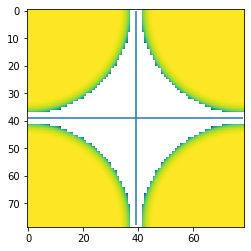

In [330]:
plt.imshow(np.log10(tukey_filter))
print(np.max(tukey_filter))
plt.hlines(0.5*(nx-1),0,nx-1)
plt.vlines(0.5*(nx-1),0,nx-1)

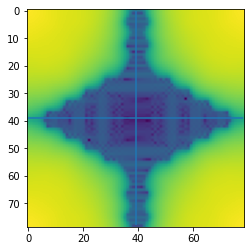

In [332]:
plt.imshow(tf.math.log(tf.math.abs(data_F200W_fft)))
plt.hlines(0.5*(nx-1),0,nx-1)
plt.vlines(0.5*(nx-1),0,nx-1)

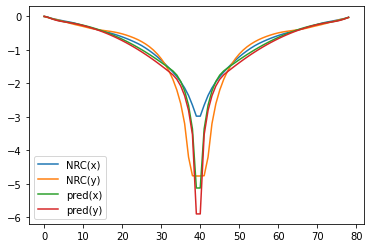

In [349]:
plt.plot(np.log10(np.absolute(data_F200W_fft[:,0])),label='NRC(x)')
plt.plot(np.log10(np.absolute(data_F200W_fft[0,:])),label='NRC(y)')
plt.plot(np.log10(np.absolute(pred_fft[:,0])),label='pred(x)')
plt.plot(np.log10(np.absolute(pred_fft[0,:])),label='pred(y)')
plt.legend()

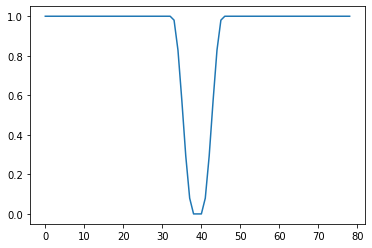

In [334]:
plt.plot(tukey_filter[0,:])

0.9939003


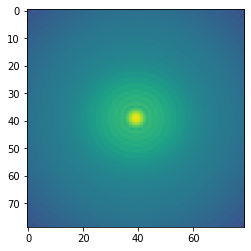

In [335]:
plt.imshow(np.log10(pred),vmin=-8.1,vmax=-0.8)
print(np.sum(pred))

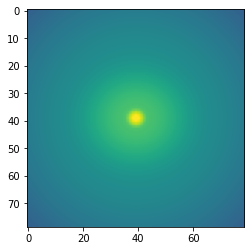

In [336]:
plt.imshow(np.log10(mvn_three_fit(xy)),vmin=-8.1,vmax=-0.8)

-7.082241703057262 -0.8963578266473058


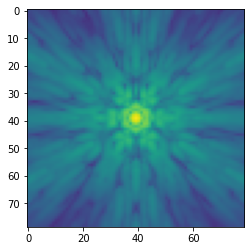

In [337]:
plt.imshow(np.log10(data_F200W),vmin=-8.1,vmax=-0.8)
print(np.min(np.log10(data_F200W)),np.max(np.log10(data_F200W)))

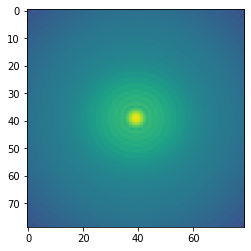

In [338]:
plt.imshow(np.log10(pred),vmin=-8.1,vmax=-0.8)

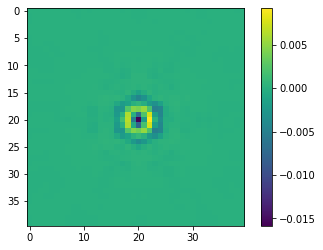

In [340]:
imin = int(0.5*(nx-1)) - 20
imax = int(0.5*(nx-1)) + 20

plt.imshow((pred[imin:imax,imin:imax]-data_F200W[imin:imax,imin:imax]))
plt.colorbar()

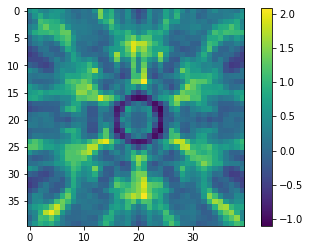

In [345]:
imin = int(0.5*(nx-1)) - 20
imax = int(0.5*(nx-1)) + 20

plt.imshow((np.log10(pred[imin:imax,imin:imax])-np.log10(data_F200W[imin:imax,imin:imax])))
plt.colorbar()

-6.798819685423755 -0.8963578266473058


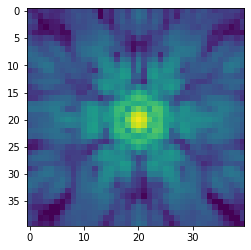

In [341]:
imin = int(0.5*(nx-1)) - 20
imax = int(0.5*(nx-1)) + 20
plt.imshow(np.log10(data_F200W[imin:imax,imin:imax]),vmin=-6.1,vmax=-0.8)
print(np.min(np.log10(data_F200W[imin:imax,imin:imax])),np.max(np.log10(data_F200W[imin:imax,imin:imax])))

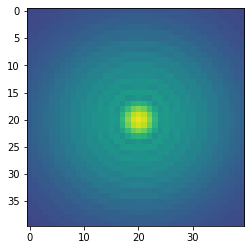

In [342]:
imin = int(0.5*(nx-1)) - 20
imax = int(0.5*(nx-1)) + 20
plt.imshow(np.log10(pred[imin:imax,imin:imax]),vmin=-6.1,vmax=-0.8)

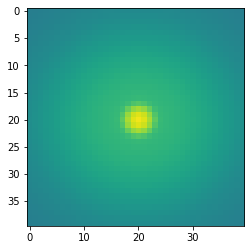

In [343]:
imin = int(0.5*(nx-1)) - 20
imax = int(0.5*(nx-1)) + 20
pmvn = mvn_three_fit(xy)
plt.imshow(np.log10(pmvn[imin:imax,imin:imax]/np.sum(pmvn)),vmin=-8.1,vmax=-0.8)


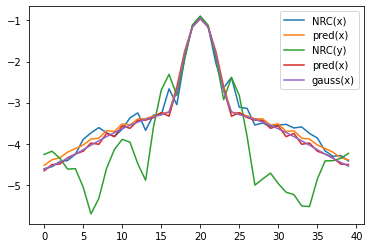

In [347]:
imin = int(0.5*(nx-1)) - 20
imax = int(0.5*(nx-1)) + 20
plt.plot(np.log10(data_F200W[int(0.5*(nx-1)),imin:imax]),label='NRC(x)')
plt.plot(np.log10(pred[int(0.5*(nx-1)),imin:imax]),label='pred(x)')
plt.plot(np.log10(data_F200W[imin:imax,int(0.5*(nx-1))]),label='NRC(y)')
plt.plot(np.log10(pred[imin:imax,int(0.5*(nx-1))]),label='pred(x)')
plt.plot(np.log10(pmvn[imin:imax,int(0.5*(nx-1))]/np.sum(pmvn)),label='gauss(x)')
plt.legend()

## Test on DC2 images

In [350]:
import sys
import os
sys.path.insert(0,'/home/brant/github/jades-sources/notebooks/')
from jades_lib import paths as jades_paths
import numpy as np
import matplotlib.pyplot as plt
from jades_utils import quicklook as jql
from astropy.io import fits

In [351]:
jlp = jades_paths()

In [352]:
print(jlp.data_root)

/data/groups/comp-astro/jades/jades-data/


In [353]:
os.listdir(path=jlp.data_root)

['GOODS-N',
 '.dvc',
 'UDS',
 'EGS',
 'fake.dat',
 '.gitignore',
 '.git',
 'GOODS-S',
 '.dvcignore',
 'workflows.md',
 'fake.dat.dvc',
 'README.md',
 'Guitarra']

In [354]:
data_dc2 = jlp.data_root + "Guitarra/images/JWST/DC2-mosaics/v6/"

In [355]:
os.listdir(path=data_dc2)

['F410M',
 'F115W',
 'F356W',
 'F277W',
 'F150W',
 'F444W',
 'F335M',
 'F090W',
 'F200W',
 'copy_files.sh']

In [356]:
fdir_F200W = data_dc2+"F200W/"

In [357]:
os.listdir(path=fdir_F200W)

['F200W_conv_LWpix.fits.dvc',
 'F200W_err_conv.fits.dvc',
 'F200W.fits.dvc',
 'F200W_exp.fits.dvc',
 '.gitignore',
 'F200W_conv.fits',
 'readme.md',
 'F200W_err_conv_LWpix.fits.dvc',
 'F200W_err_conv_LWpix.fits',
 'F200W_err.fits',
 'F200W_exp.fits',
 'F200W.fits',
 'README.md',
 'F200W_conv_LWpix.fits',
 'F200W_err_conv.fits',
 'F200W_conv.fits.dvc',
 'F200W_err.fits.dvc']

In [358]:
fname_F200W_flux_fits = fdir_F200W+"F200W.fits"
fname_F200W_ferr_fits = fdir_F200W+"F200W_err.fits"

In [359]:
hdu_F200W_flux = fits.open(fname_F200W_flux_fits)
hdu_F200W_ferr = fits.open(fname_F200W_ferr_fits)

In [360]:
data_F200W_flux = hdu_F200W_flux[0].data
data_F200W_ferr = hdu_F200W_ferr[0].data

In [361]:
xmin = 10000
xmax = 12000
ymin = 10000
ymax = 12000
data_flux = jql.cutout(data_F200W_flux,xmin,xmax,ymin,ymax)
data_ferr = jql.cutout(data_F200W_ferr,xmin,xmax,ymin,ymax)

In [362]:
data_flux = data_flux.byteswap(inplace=True).newbyteorder()
data_ferr = data_ferr.byteswap(inplace=True).newbyteorder()

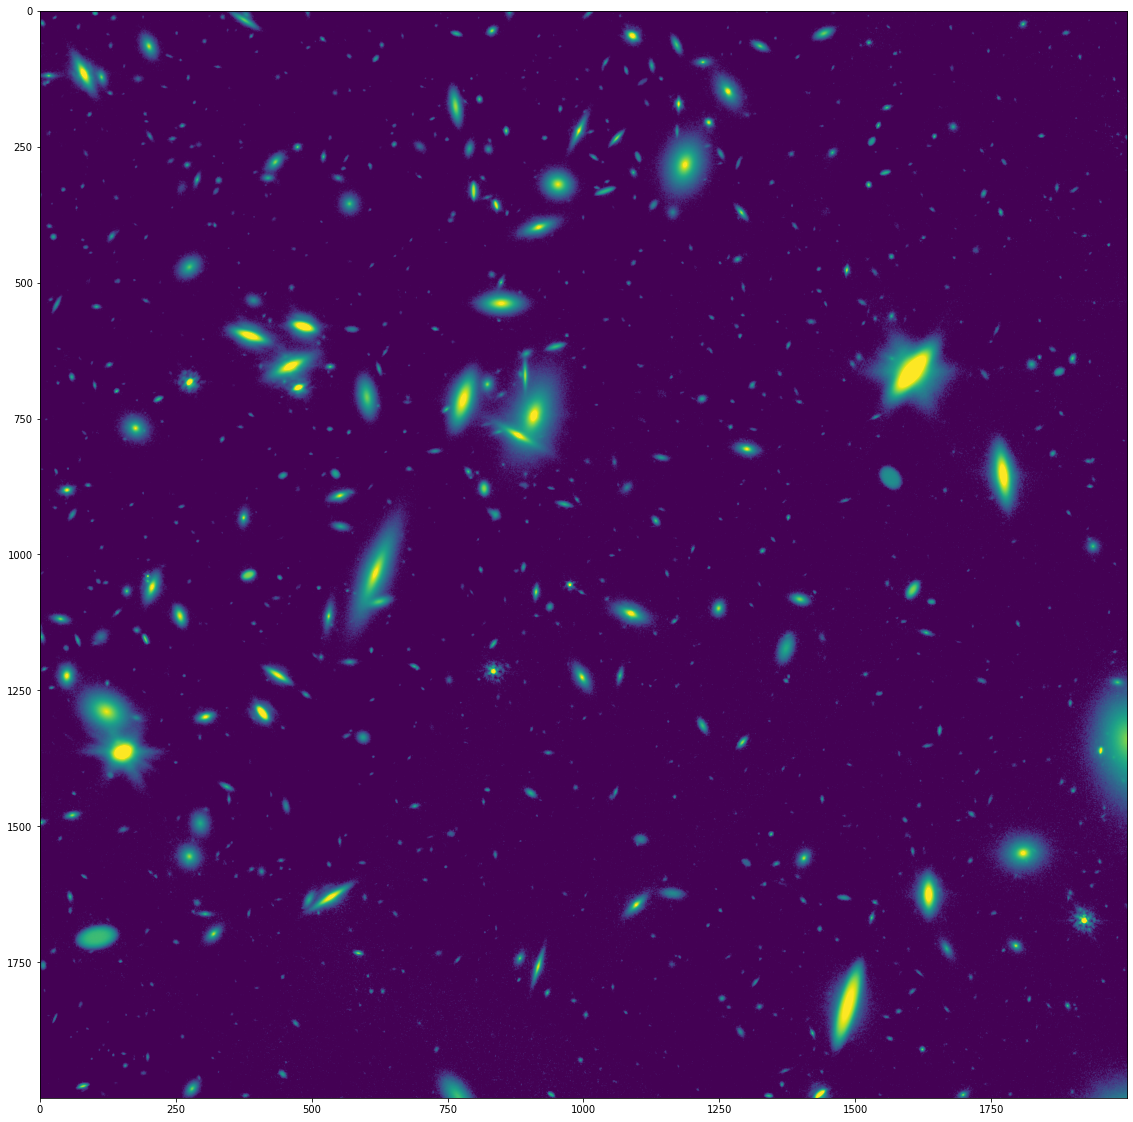

In [363]:
jql.imshow(data_flux,fnx=20,fny=20,flag_log=True)

In [375]:
from scipy.signal import convolve2d,deconvolve
psf_F444W = data_F200W #kludge
data_flux_imed = deconvolve(data_flux.astype(float),psf_F444W.astype(float))
data_flux_test = convolve2d(data_flux_imed,pred,mode='valid')


ValueError: could not convert b, a, and x to a common type

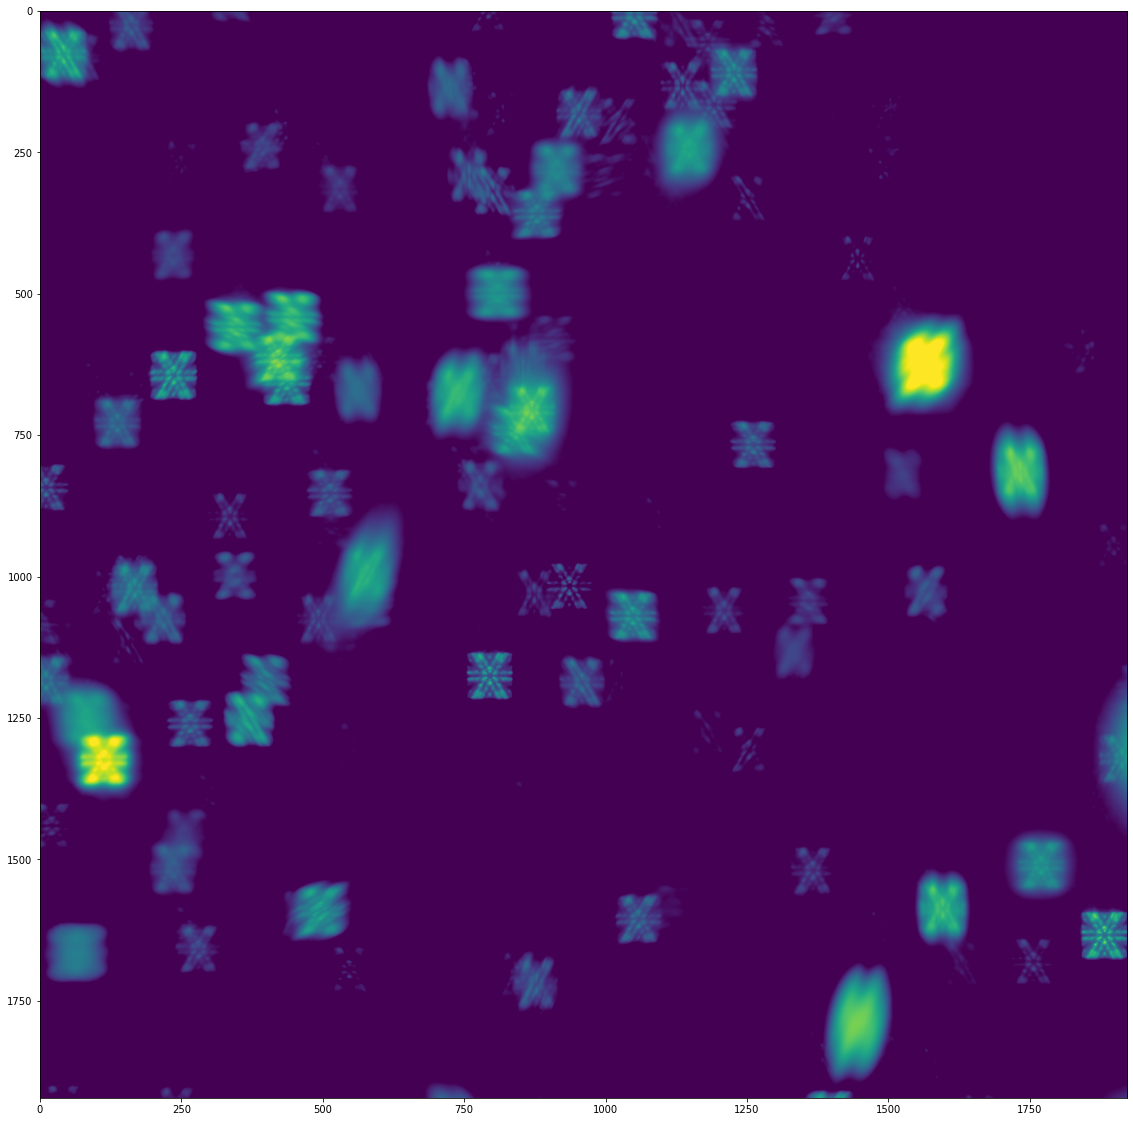

In [368]:
jql.imshow(data_flux_test,fnx=20,fny=20,flag_log=True)

In [376]:
from scipy import fftpack

def convolve(star, psf):
    star_fft = fftpack.fftshift(fftpack.fftn(star))
    psf_fft = fftpack.fftshift(fftpack.fftn(psf))
    return fftpack.fftshift(fftpack.ifftn(fftpack.ifftshift(star_fft*psf_fft)))

def deconvolve(star, psf):
    star_fft = fftpack.fftshift(fftpack.fftn(star))
    psf_fft = fftpack.fftshift(fftpack.fftn(psf))
    return fftpack.fftshift(fftpack.ifftn(fftpack.ifftshift(star_fft/psf_fft)))

data_flux_imed = deconvolve(data_flux, psf_F444W)
data_flux_test = convolve2d(data_flux_imed,pred,mode='valid')

ValueError: operands could not be broadcast together with shapes (2000,2000) (79,79) 